#Amazon Delivery Time Prediction Project

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import mlflow
import mlflow.sklearn
import joblib

In [2]:
import os

In [3]:
import sys
print(sys.executable)

c:\Users\DELL\Desktop\Data-Guvi\Priya\Project 4\.venv\Scripts\python.exe


In [4]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [5]:
file_path = "amazon_delivery.xlsx" 

In [6]:
df = pd.read_excel(file_path)


In [7]:
df

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43734,jlxf819993117,30,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,Windy,High,motorcycle,Metropolitian,160,Home
43735,aevx342135787,21,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,Windy,Jam,motorcycle,Metropolitian,180,Jewelry
43736,xnek760674819,30,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Cloudy,Low,scooter,Metropolitian,80,Home
43737,cynl434665991,20,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Cloudy,High,motorcycle,Metropolitian,130,Kitchen


In [8]:
df.shape

(43739, 16)

In [9]:
type(df)

pandas.core.frame.DataFrame

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Order_ID         43739 non-null  object        
 1   Agent_Age        43739 non-null  int64         
 2   Agent_Rating     43685 non-null  float64       
 3   Store_Latitude   43739 non-null  float64       
 4   Store_Longitude  43739 non-null  float64       
 5   Drop_Latitude    43739 non-null  float64       
 6   Drop_Longitude   43739 non-null  float64       
 7   Order_Date       43739 non-null  datetime64[ns]
 8   Order_Time       43739 non-null  object        
 9   Pickup_Time      43739 non-null  object        
 10  Weather          43648 non-null  object        
 11  Traffic          43739 non-null  object        
 12  Vehicle          43739 non-null  object        
 13  Area             43739 non-null  object        
 14  Delivery_Time    43739 non-null  int64

In [11]:
df.describe()

,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Delivery_Time
count,43739.000000,43685.000000,43739.000000,43739.000000,43739.000000,43739.000000,43739,43739.000000
mean,29.567137,4.633780,17.210960,70.661177,17.459031,70.821842,2022-03-13 15:58:10.697089792,124.905645
min,15.000000,1.000000,-30.902872,-88.366217,0.010000,0.010000,2022-02-11 00:00:00,10.000000
25%,25.000000,4.500000,12.933298,73.170283,12.985996,73.280000,2022-03-04 00:00:00,90.000000
50%,30.000000,4.700000,18.551440,75.898497,18.633626,76.002574,2022-03-15 00:00:00,125.000000
75%,35.000000,4.900000,22.732225,78.045359,22.785049,78.104095,2022-03-27 00:00:00,160.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,2022-04-06 00:00:00,270.000000
std,5.815155,0.334716,7.764225,21.475005,7.342950,21.153148,NaN,51.915451


In [12]:
df.isnull().sum()

Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64

In [13]:
df = df.dropna()

In [14]:
df.isnull().sum()

Order_ID           0
Agent_Age          0
Agent_Rating       0
Store_Latitude     0
Store_Longitude    0
Drop_Latitude      0
Drop_Longitude     0
Order_Date         0
Order_Time         0
Pickup_Time        0
Weather            0
Traffic            0
Vehicle            0
Area               0
Delivery_Time      0
Category           0
dtype: int64

In [15]:
df

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43734,jlxf819993117,30,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,Windy,High,motorcycle,Metropolitian,160,Home
43735,aevx342135787,21,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,Windy,Jam,motorcycle,Metropolitian,180,Jewelry
43736,xnek760674819,30,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Cloudy,Low,scooter,Metropolitian,80,Home
43737,cynl434665991,20,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Cloudy,High,motorcycle,Metropolitian,130,Kitchen


In [16]:
df.duplicated().sum()

np.int64(0)

In [17]:
df= df.drop_duplicates()

In [18]:
df

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43734,jlxf819993117,30,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,Windy,High,motorcycle,Metropolitian,160,Home
43735,aevx342135787,21,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,Windy,Jam,motorcycle,Metropolitian,180,Jewelry
43736,xnek760674819,30,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Cloudy,Low,scooter,Metropolitian,80,Home
43737,cynl434665991,20,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Cloudy,High,motorcycle,Metropolitian,130,Kitchen


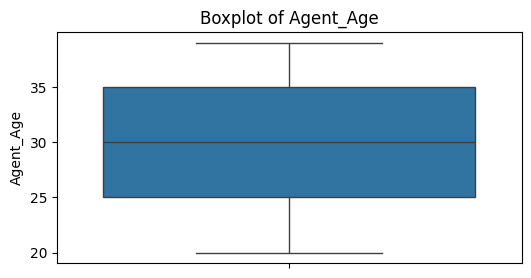

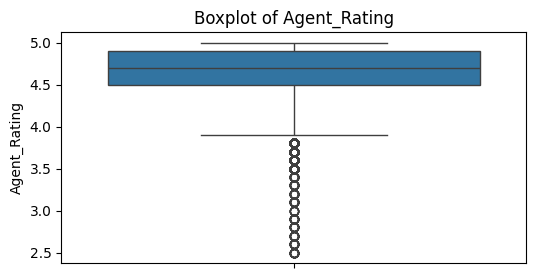

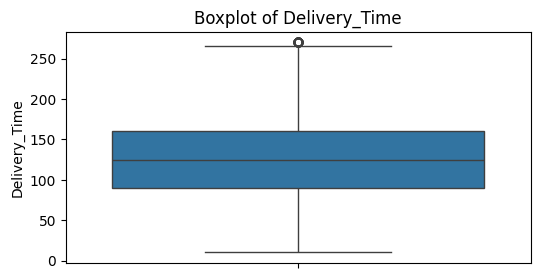

In [19]:
 # Boxplots for continuous variables
cont_cols = ['Agent_Age', 'Agent_Rating', 'Delivery_Time']
for col in cont_cols:
        plt.figure(figsize=(6, 3))
        sns.boxplot(df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

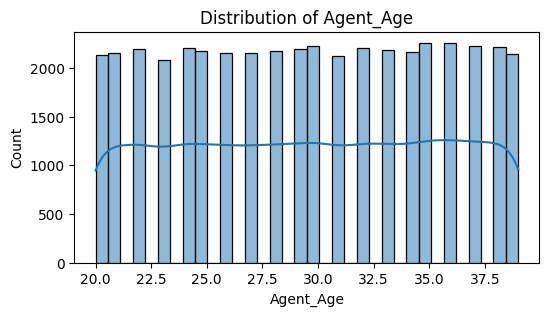

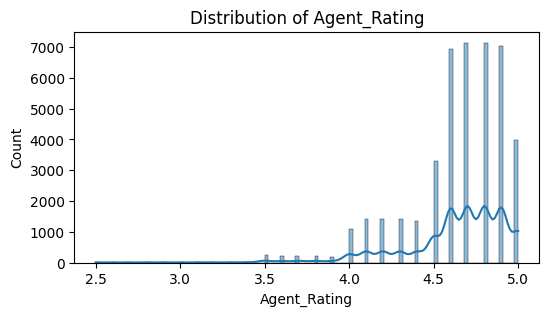

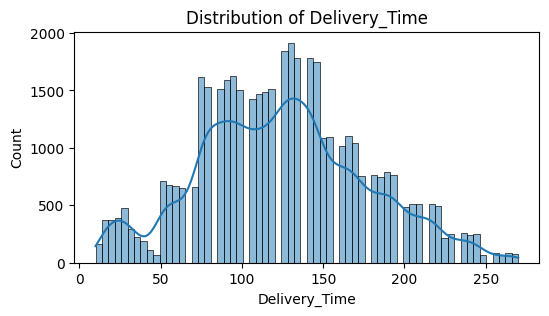

In [20]:
 # Distribution plots
for col in cont_cols:
        plt.figure(figsize=(6, 3))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

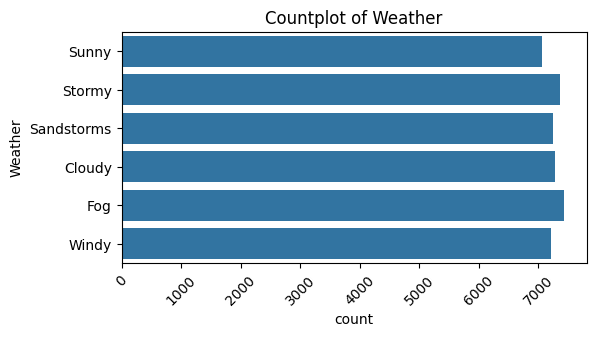

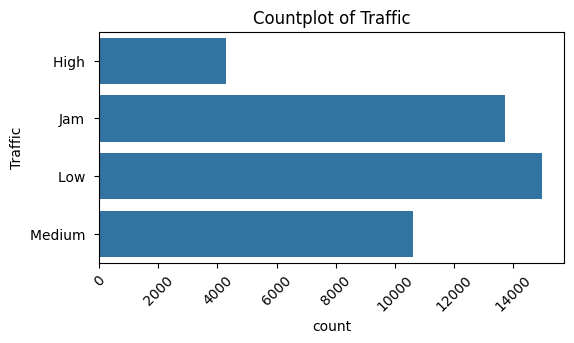

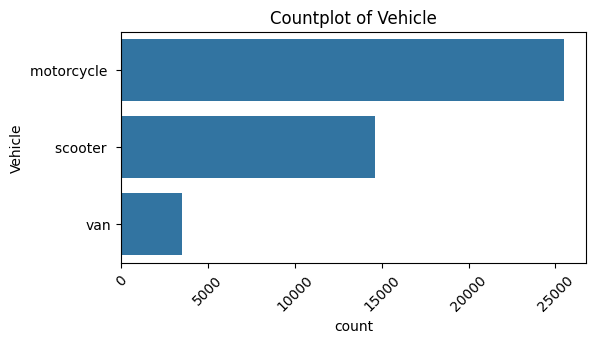

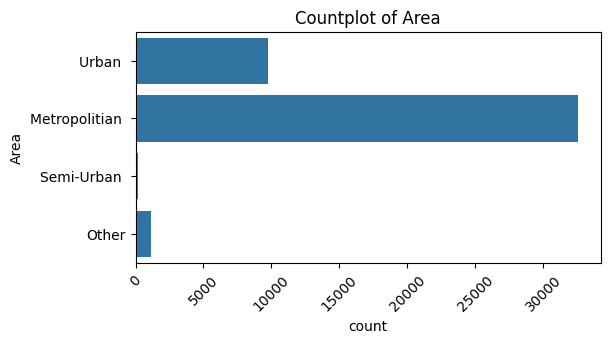

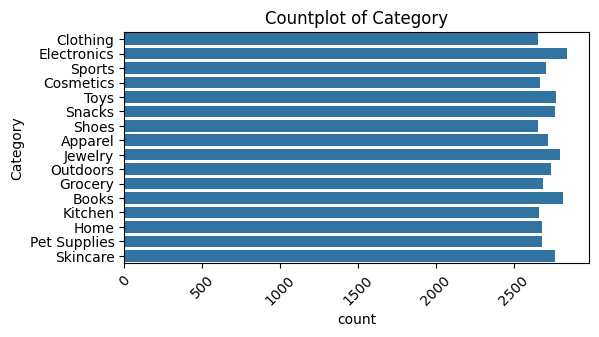

In [21]:
# Countplots for categorical
cat_cols = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
for col in cat_cols:
        plt.figure(figsize=(6, 3))
        sns.countplot(df[col])
        plt.title(f"Countplot of {col}")
        plt.xticks(rotation=45)
        plt.show()

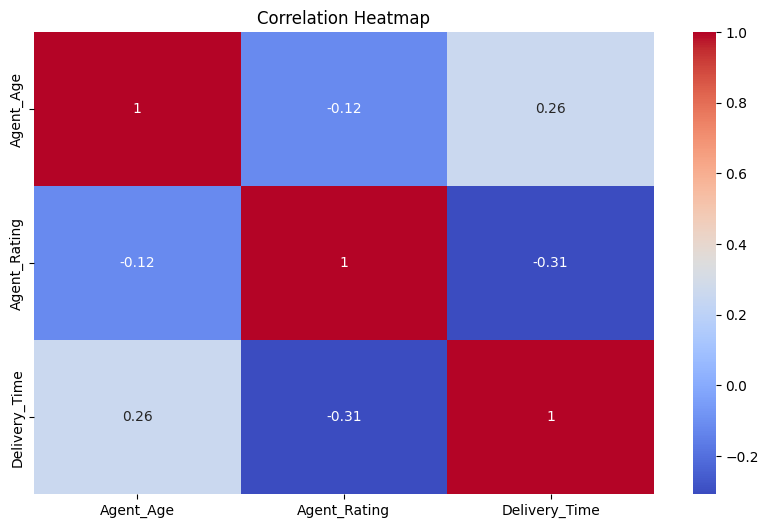

In [22]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[cont_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

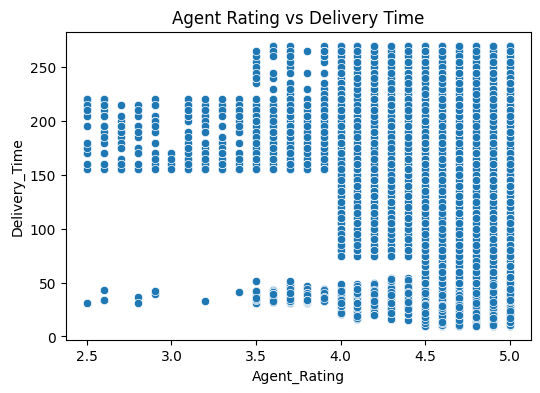

In [23]:
# Scatter plots
plt.figure(figsize=(6, 4))
sns.scatterplot(df, x='Agent_Rating', y='Delivery_Time')
plt.title("Agent Rating vs Delivery Time")
plt.show()

In [24]:
df.groupby('Area')['Delivery_Time'].mean()

Area
Metropolitian     129.709039
Other             104.525110
Semi-Urban        238.552632
Urban             109.442512
Name: Delivery_Time, dtype: float64

In [25]:
for col in cont_cols:
    print(f"{col}: {df[col].skew():.2f}")

Agent_Age: -0.01
Agent_Rating: -1.79
Delivery_Time: 0.19


In [26]:
df['Order_Hour'] = df['Order_Time'].apply(lambda x: x.hour)
df['Order_DayOfWeek'] = df['Order_Date'].dt.dayofweek
df['Order_Month'] = df['Order_Date'].dt.month

In [27]:
print(df.columns)

Index(['Order_ID', 'Agent_Age', 'Agent_Rating', 'Store_Latitude',
       'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date',
       'Order_Time', 'Pickup_Time', 'Weather', 'Traffic', 'Vehicle', 'Area',
       'Delivery_Time', 'Category', 'Order_Hour', 'Order_DayOfWeek',
       'Order_Month'],
      dtype='object')


In [28]:
def calc_distance(row):
    store = (row['Store_Latitude'], row['Store_Longitude'])
    drop = (row['Drop_Latitude'], row['Drop_Longitude'])
    return geodesic(store, drop).km

In [29]:
df['Distance'] = df.apply(calc_distance, axis=1)

In [30]:
df

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Order_Hour,Order_DayOfWeek,Order_Month,Distance
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing,11,5,3,3.020737
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics,19,4,3,20.143737
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports,8,5,3,1.549693
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,18,1,4,7.774497
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys,13,5,3,6.197898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43734,jlxf819993117,30,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,Windy,High,motorcycle,Metropolitian,160,Home,11,3,3,1.488112
43735,aevx342135787,21,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,Windy,Jam,motorcycle,Metropolitian,180,Jewelry,19,2,2,10.983242
43736,xnek760674819,30,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Cloudy,Low,scooter,Metropolitian,80,Home,23,4,3,4.648024
43737,cynl434665991,20,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Cloudy,High,motorcycle,Metropolitian,130,Kitchen,13,0,3,6.219668


In [31]:
df['Distance']

0         3.020737
1        20.143737
2         1.549693
3         7.774497
4         6.197898
           ...    
43734     1.488112
43735    10.983242
43736     4.648024
43737     6.219668
43738    12.057294
Name: Distance, Length: 43594, dtype: float64

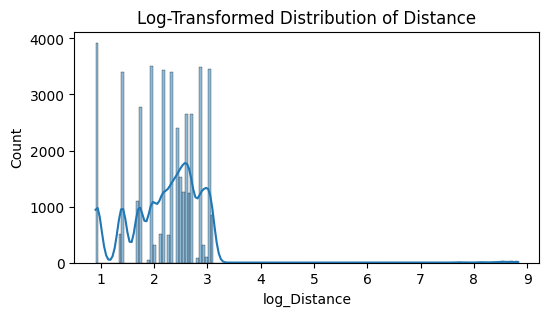

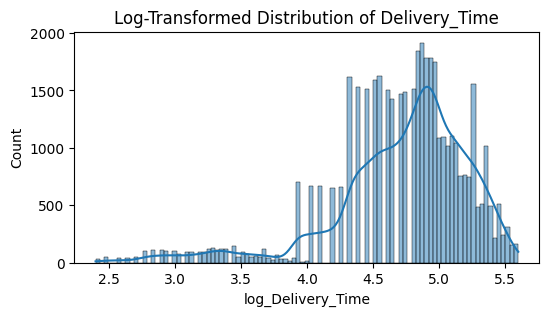

In [32]:
for col in ['Distance', 'Delivery_Time']:
    df[f'log_{col}'] = np.log1p(df[col])
    plt.figure(figsize=(6, 3))
    sns.histplot(df[f'log_{col}'], kde=True)
    plt.title(f"Log-Transformed Distribution of {col}")
    plt.show()

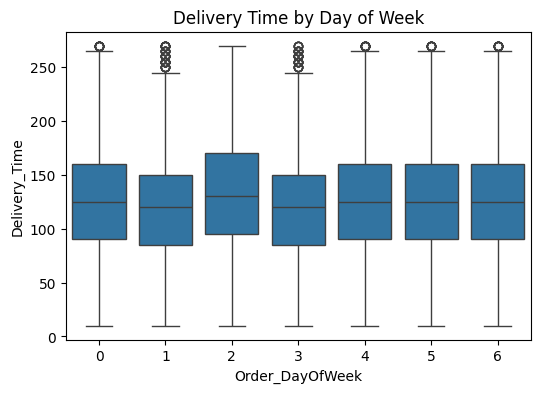

In [33]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Order_DayOfWeek', y='Delivery_Time')
plt.title("Delivery Time by Day of Week")
plt.show()

In [34]:
df[cont_cols].std()

Agent_Age         5.760689
Agent_Rating      0.313827
Delivery_Time    51.941975
dtype: float64

In [35]:
os.makedirs("models", exist_ok=True)

In [36]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [40]:
# Features and target
features = ['Distance', 'Agent_Rating', 'Area', 'Order_Hour']
target = 'Delivery_Time'

X = df[features]
y = df[target]

# Define categorical and numerical features
categorical_features = ['Area']
numerical_features = ['Distance', 'Agent_Rating', 'Order_Hour']

# Split data into train and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Preprocessor pipeline
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scale', StandardScaler(), numerical_features)
])


In [41]:
# Fit and transform train, transform test
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

In [42]:
# Extract feature names after preprocessing once, save separately
onehot_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(onehot_feature_names)
joblib.dump(feature_names, "models/feature_names.pkl")
joblib.dump(preprocessor, "models/preprocessor.pkl")

['models/preprocessor.pkl']

In [47]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "XGBoost" : XGBRegressor(),

}

In [48]:
# Set MLflow experiment
mlflow.set_experiment("Amazon Delivery Time Prediction")

for model_type, model in models.items():
    mlflow.sklearn.autolog(log_input_examples=False) 

    with mlflow.start_run(run_name=model_type):
        # Log project name as a param inside the run
        mlflow.log_param("project_name", "Amazon Delivery Time Prediction")

        model.fit(X_train, y_train.values)
        preds = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        model_path = f"models/{model_type}_model.pkl"
        joblib.dump(model, model_path)
        mlflow.log_artifact(model_path)

        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)

        print(f"{model_type} => RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")


LinearRegression => RMSE: 47.23, MAE: 36.67, R2: 0.15
RandomForest => RMSE: 47.52, MAE: 36.10, R2: 0.14
Gradient Boosting Regressor => RMSE: 42.23, MAE: 31.65, R2: 0.32
XGBoost => RMSE: 43.14, MAE: 32.38, R2: 0.29
